In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer, MissingIndicator
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import pylab
import random

## 3. Data preparation

Prepare data for machine learning

In [2]:
listing3 = pd.read_csv("temp/listing26.csv")
listing3.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,...,amenity_Free street parking,amenity_Fixed grab bars for shower,amenity_Pack ’n Play/travel crib,amenity_Wheelchair accessible,amenity_Outlet covers,amenity_Smoking allowed,amenity_Firm mattress,price_per_person,comments_sentiment,comments_word_count
0,2384,2613,2008-08-29,NaN,NaN,1,1,1,1,Hyde Park,...,1,0,0,0,0,0,0,50.000000,1.0000,76.887218
1,4505,5775,2008-12-29,1.0,100.0,1,1,1,1,Little Village,...,1,0,0,0,0,0,0,17.142857,1.0000,83.942149
2,6715,15365,2009-04-30,NaN,NaN,0,2,1,0,Lincoln Park,...,0,0,1,0,0,0,0,31.875000,1.0000,63.462366
3,9811,33004,2009-08-21,1.0,100.0,0,8,1,1,Old Town,...,0,0,0,0,0,0,0,37.500000,1.0000,48.400000
4,10610,2140,2008-08-16,1.0,100.0,0,5,1,1,Hyde Park,...,1,0,0,0,0,0,0,17.500000,0.9999,54.806452


In [3]:
listing3.dtypes.loc[listing3.dtypes == 'object']

host_since             object
neighbourhood          object
zipcode                object
property_type          object
room_type              object
bed_type               object
cancellation_policy    object
dtype: object

### 3.1. Re-encode features

In [4]:
# Drop host_since datetime column, etc.
listing3 = listing3.drop(columns=['host_since', 'latitude', 'longitude'])

In [5]:
# Re-encode zipcode column
print(listing3['zipcode'].unique())
listing3['zipcode'] = listing3['zipcode'].map(lambda x: x.split('-')[0] if type(x) != float else np.nan)

['60637' '60608' '60614' '60615' '60610' '60642' '60613' '60640' '60654'
 '60657' '60622' '60647' '60612' '60618' '60641' '60628' '60660' '60616'
 '60601' '60645' '60619' '60606' '60609' '60625' '60653' '60626' '60646'
 '60659' '60607' '60611' '60623' '60644' '60624' '60631' '60643' '60656'
 '60602' '60661' '60630' '60634' '60629' '60649' '60605' '60660-1448'
 '60617' '60620' '60651' '60633' '60639' '60621' '60632' '60302' '60652'
 '60638' '60304' nan '60651-2248' '60707' '60618-4226' '60636'
 '60601-7526' '60649-2269' '60805' '60827' '60655' '60603' '60622-3541'
 '60637-3932' '60612-1835' '60534' '60706' '60501']


In [6]:
# One-hot encoding
col_names = ['neighbourhood', 'zipcode', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']
listing3 = pd.get_dummies(listing3, prefix=col_names)

In [7]:
# Drop id columns
listing3 = listing3.drop(columns=['id', 'host_id'])

### 3.2. Assess missing data

#### Assess missing data in columns

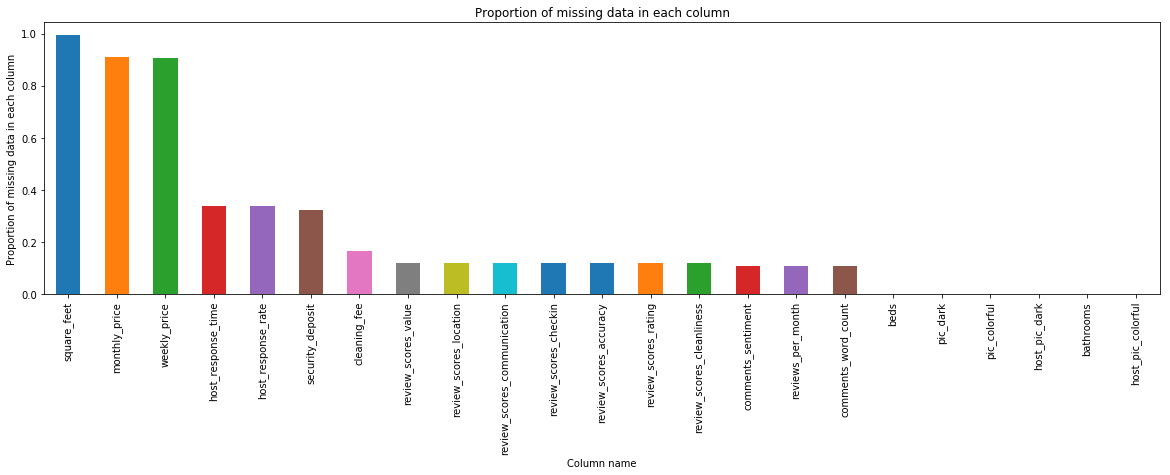

In [8]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_col = listing3.isnull().sum() / len(listing3.index)

# Investigate patterns in the amount of missing data in each column.
missing_col.loc[missing_col>0].sort_values(ascending=False).plot.bar(figsize=(20,5))
plt.xlabel("Column name")
plt.ylabel("Proportion of missing data in each column")
plt.title("Proportion of missing data in each column");

Remove columns with >80% missing data

In [9]:
# Remove columns with >80% missing data
listing32 = listing3.drop(columns=['square_feet', 'monthly_price', 'weekly_price'])

#### Assess missing data in rows

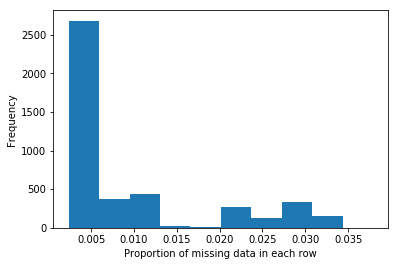

In [10]:
# Plot missing values in rows
missing_row = listing32.isnull().sum(axis=1) / len(listing32.columns)
missing_row.loc[missing_row>0].sort_values(ascending=False).plot.hist()
plt.xlabel("Proportion of missing data in each row");

Remove rows with >0.015 missing data

In [11]:
# Remove rows with >0.015 missing data
listing32 = listing32.loc[missing_row < 0.015]

Re-assess missing data in columns

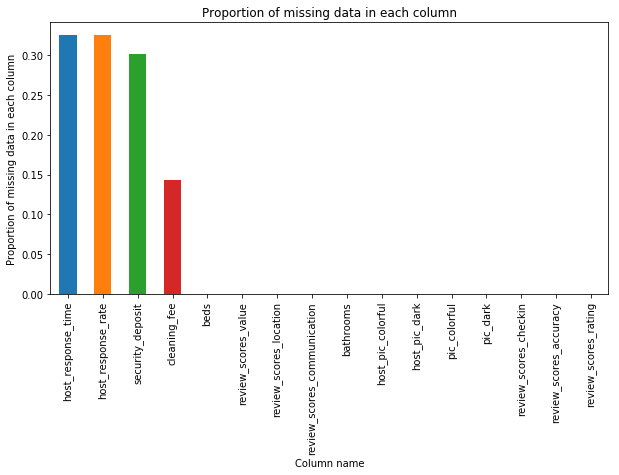

In [12]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_col = listing32.isnull().sum() / len(listing32.index)

# Investigate patterns in the amount of missing data in each column.
missing_col.loc[missing_col>0].sort_values(ascending=False).plot.bar(figsize=(10,5))
plt.xlabel("Column name")
plt.ylabel("Proportion of missing data in each column")
plt.title("Proportion of missing data in each column");

In [13]:
# Identify columns with missing values to impute
missing_col_names = missing_col.loc[missing_col>0].index.tolist()

# Make new columns indicating what will be imputed
missing_indicators = {}
for col in missing_col_names:
    missing_indicator_name = col+'_was_missing'
    missing_indicator = MissingIndicator()
    X = listing32[col].values.reshape(-1, 1)
    missing_indicator.fit(X)
    listing32[missing_indicator_name] = missing_indicator.transform(X) * 1
    missing_indicators[col] = missing_indicator

# Impute missing values in other columns
missing_imputers = {}
for col in missing_col_names:
    missing_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    X = listing32[col].values.reshape(-1, 1)
    missing_imputer.fit(X)
    listing32[col] = missing_imputer.transform(X)
    missing_imputers[col] = missing_imputer

In [14]:
missing_value_count = listing32.isnull().sum().sum()
print(f"{missing_value_count} missing value left.")

0 missing value left.


### 3.3 Feature transformation and scaling

Examine feature distributions (check multivariate normality)

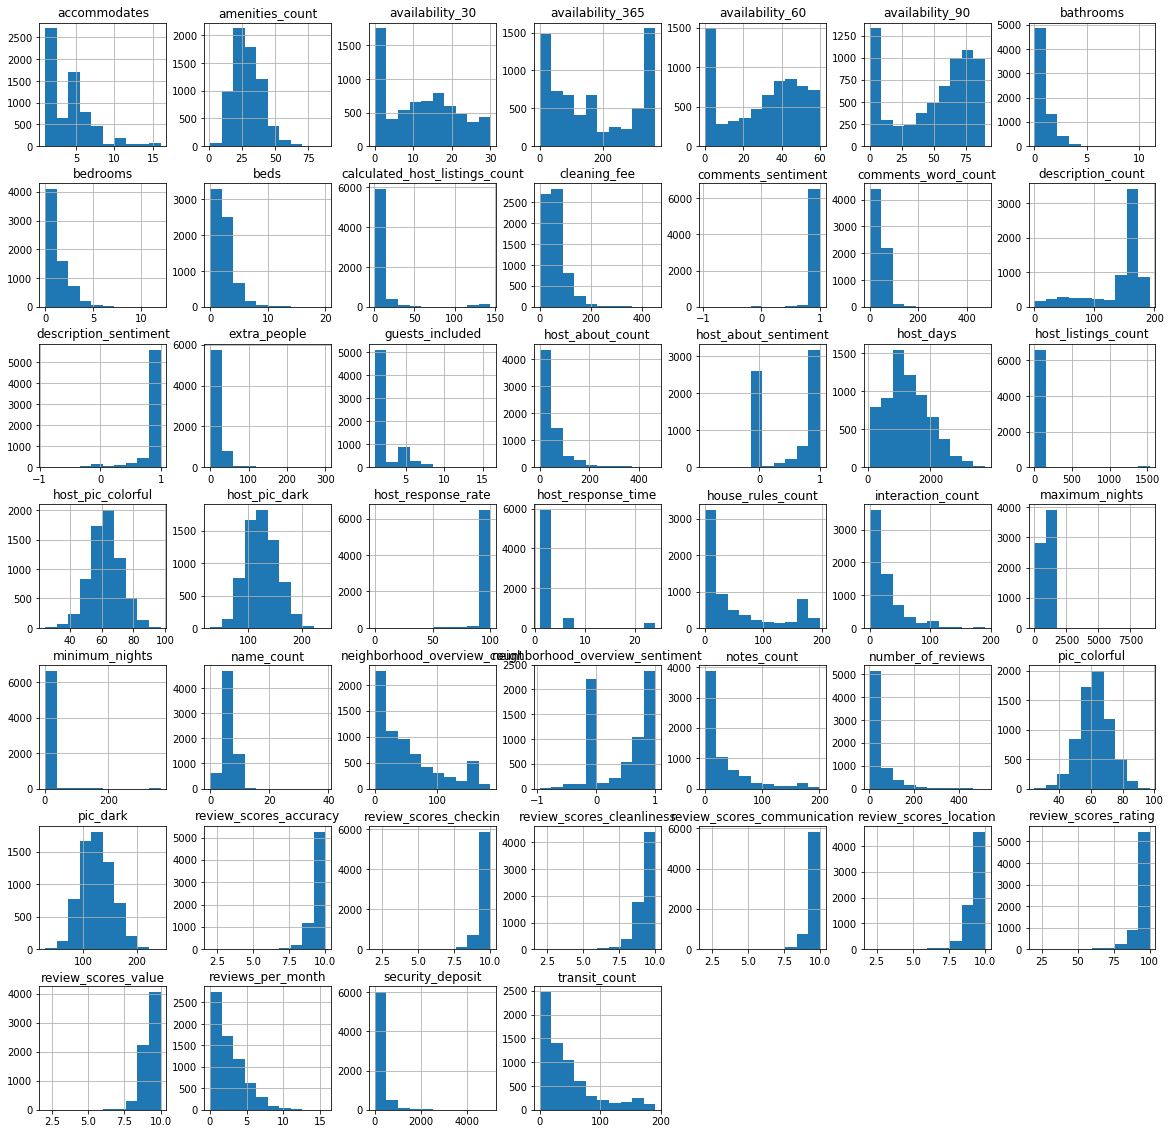

In [15]:
# Examine feature distributions (excluding binary features)
col_names = [col for col in listing32.columns if 
             ('menity' not in col) and 
             ('is_' not in col) and
             ('require' not in col) and
             ('host_has' not in col) and
             ('instant' not in col) and
             ('neighbourhood' not in col) and
             ('zipcode' not in col) and
             ('type' not in col) and
             ('was_missing' not in col) and
             ('cancellation_policy' not in col) and
             ('host_identity_verified' not in col) and
             ('price' not in col)
            ]
listing32[col_names].hist(figsize=(20,20));

Transform skewed features using Box-Cox power transformation. Features that already have normal-ish distributions are excluded.

In [16]:
# Skewed features
to_transform = [col for col in col_names if 
                 ('pic' not in col) and 
                 ('amenities_count' not in col) and
                 ('host_days' not in col)
               ]
listing33 = listing32.copy()

# Shift values of those features so they are all positive
for col in to_transform:
    listing33[col] = listing33[col] - listing33[col].min() + 1
    listing33[col] = boxcox(listing33[col])[0]

# # Log-transform the skewed features
# listing33[to_transform] = listing33[to_transform].apply(lambda x: np.log(x))

# # Examine feature distributions after transformation
# listing33[to_transform].hist(figsize=(20,20));

Check multivariate normality

<Figure size 432x288 with 0 Axes>

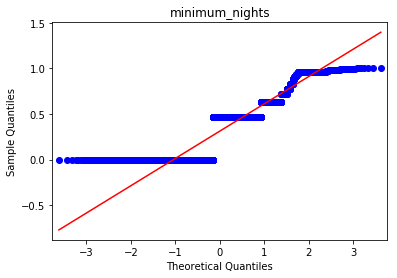

<Figure size 432x288 with 0 Axes>

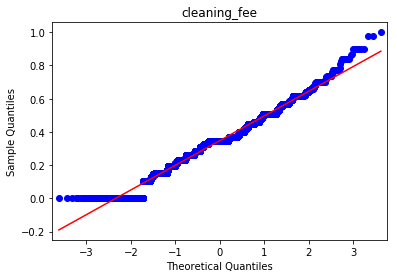

In [27]:
for col in random.sample(to_transform, 2):
    plt.figure();
    sm.qqplot(listing33[col], line='s');
    plt.title(f"{col}");
    pylab.show();

Apply feature scaling to non-binary features

In [18]:
# Apply feature scaling to the features (excluding price)
to_scale = col_names

# Rescale features between range of 0 and 1
scaler_mm = MinMaxScaler()
listing33[to_scale] = scaler_mm.fit_transform(listing33[to_scale])

# # Examine feature distributions after scaling
# listing33[to_scale].hist(figsize=(20,20));

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Save as a checkpoint

In [19]:
listing33.to_csv("temp/listing33.csv", index=False)

### 3.4. Check multicollinearity

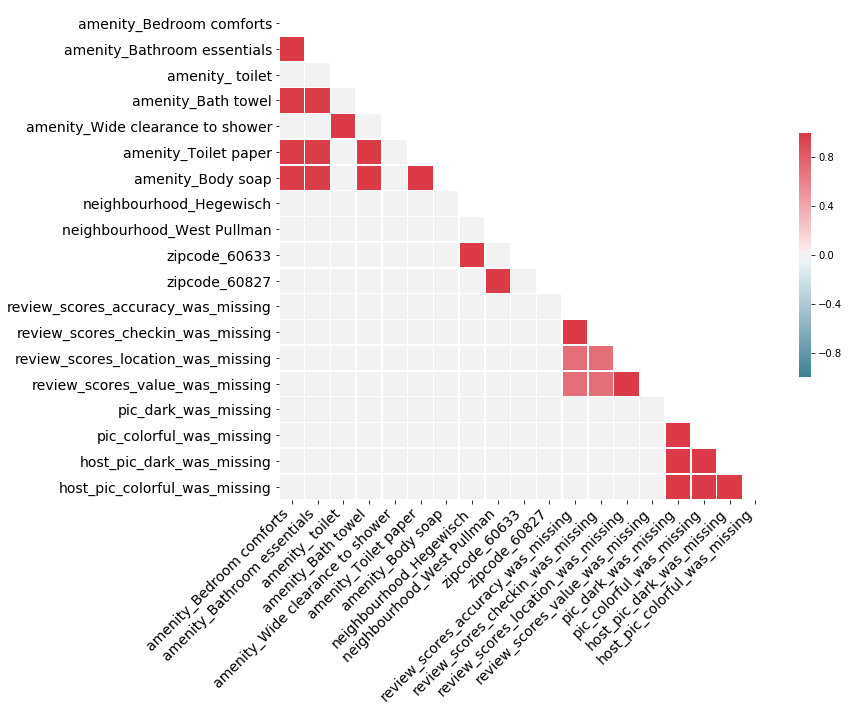

In [20]:
listing34 = pd.read_csv("temp/listing33.csv")

# Find features that have correlation = 1
corr_matrix = listing34.corr()
correlated_cols = (corr_matrix.abs() == 1).sum().loc[(corr_matrix == 1).sum()>1].index.tolist()

# Visualize their correlations
# sns.set(style="white")
corr = listing34[correlated_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            xticklabels=correlated_cols,
            yticklabels=correlated_cols,
#             annot=True
                )
plt.xticks(rotation=45, ha='right', fontsize=14) 
plt.yticks(fontsize=14);
# ax.figure.axes[-1].yaxis.label.set_size(14)
# print(correlated_cols)

Columns that have high correlation with others are dropped

In [21]:
# Drop those columns that strongly correlate with others
tst = corr.abs()
tst[tst.columns.tolist()] = np.triu(tst, 1) # turn lower diagonal of the matrix to be zero 
to_drop = tst.sum(axis=1).loc[tst.sum(axis=1)>=1].index.tolist()
listing34 = listing34.drop(columns=to_drop)
[print(f"Column {col} dropped") for col in to_drop];

Column amenity_Bedroom comforts dropped
Column amenity_Bathroom essentials dropped
Column amenity_ toilet dropped
Column amenity_Bath towel dropped
Column amenity_Toilet paper dropped
Column neighbourhood_Hegewisch dropped
Column neighbourhood_West Pullman dropped
Column review_scores_accuracy_was_missing dropped
Column review_scores_checkin_was_missing dropped
Column review_scores_location_was_missing dropped
Column pic_dark_was_missing dropped
Column pic_colorful_was_missing dropped
Column host_pic_dark_was_missing dropped


In [22]:
# Save as a checkpoint
listing34.to_csv("temp/listing34.csv", index=False)